In [1]:
from scipy import stats, sparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import sys

sys.path.append(str(Path('').absolute().parent))

In [2]:
ROOT = Path('.').absolute().parent
DATA_DIR = ROOT / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'

In [3]:
[*RAW_DATA_DIR.rglob('*')]

[PosixPath('/home/gabriel/Documents/2021_1sem/datasci4heatlh/data/raw/egfr_erbB1.h5'),
 PosixPath('/home/gabriel/Documents/2021_1sem/datasci4heatlh/data/raw/test'),
 PosixPath('/home/gabriel/Documents/2021_1sem/datasci4heatlh/data/raw/train'),
 PosixPath('/home/gabriel/Documents/2021_1sem/datasci4heatlh/data/raw/test/sparse_test_y.npz'),
 PosixPath('/home/gabriel/Documents/2021_1sem/datasci4heatlh/data/raw/test/sparse_test_X.npz'),
 PosixPath('/home/gabriel/Documents/2021_1sem/datasci4heatlh/data/raw/train/sparse_train_X.npz'),
 PosixPath('/home/gabriel/Documents/2021_1sem/datasci4heatlh/data/raw/train/sparse_train_y.npz')]

# Carregar dados

In [4]:
train_X_csr = sparse.load_npz(RAW_DATA_DIR / 'train' / 'sparse_train_X.npz')
train_y_csr = sparse.load_npz(RAW_DATA_DIR / 'train' / 'sparse_train_y.npz')

**Para numpy arrays**

In [5]:
train_X = train_X_csr.toarray()
train_y = train_y_csr.toarray().squeeze()

# Pipelines de modelagem

## Algoritmos baseados em árvores de decisão

In [6]:
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier)
from sklearn.model_selection import RandomizedSearchCV

### Baseados em Bagging

In [32]:
bagging_param_distribs = {
    'n_estimators': stats.randint(50, 250),
    'criterion': ['gini', 'entropy'],
    'max_depth': stats.randint(1, 20),
    'min_samples_leaf': stats.randint(5, 50),
    'max_samples': stats.loguniform(3e-1, 1)
}

In [33]:
bagging_estimators = {
    'xtrees': ExtraTreesClassifier(random_state=123),
    'rf': RandomForestClassifier(random_state=123)
}
search_objs = {}

for name, estimator in bagging_estimators.items():
    rnd_search_cv = RandomizedSearchCV(estimator,
                                       param_distributions=bagging_param_distribs,
                                       scoring='accuracy', cv=5, n_iter=50, random_state=123,
                                       return_train_score=True, verbose=2, n_jobs=-1)
    rnd_search_cv.fit(train_X, train_y)
    search_objs[name] = rnd_search_cv

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [34]:
search_objs['rf'].cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_criterion', 'param_max_depth', 'param_max_samples', 'param_min_samples_leaf', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [35]:
top_n = 5

for name in bagging_estimators:
    print(name, '-'*50)
    cv_test_scores = search_objs[name].cv_results_['mean_test_score']
    top_results_idx = [*reversed(np.argsort(cv_test_scores))][:top_n]
    for i, idx in enumerate(top_results_idx):
        print(f'# {i}')
        print('test_score: {:.4f}'.format(cv_test_scores[idx]))
        for param in bagging_param_distribs:
            param_samples = search_objs[name].cv_results_[f'param_{param}']
            print(f'{param}: ', param_samples[idx])

xtrees --------------------------------------------------
# 0
test_score: 0.8232
n_estimators:  189
criterion:  gini
max_depth:  18
min_samples_leaf:  8
max_samples:  0.6879025773510774
# 1
test_score: 0.8114
n_estimators:  155
criterion:  gini
max_depth:  16
min_samples_leaf:  12
max_samples:  0.6439261050375636
# 2
test_score: 0.8111
n_estimators:  159
criterion:  entropy
max_depth:  13
min_samples_leaf:  11
max_samples:  0.9349802999603081
# 3
test_score: 0.8099
n_estimators:  186
criterion:  entropy
max_depth:  18
min_samples_leaf:  15
max_samples:  0.6679884088472051
# 4
test_score: 0.8056
n_estimators:  138
criterion:  entropy
max_depth:  13
min_samples_leaf:  12
max_samples:  0.47413993117704734
rf --------------------------------------------------
# 0
test_score: 0.8114
n_estimators:  189
criterion:  gini
max_depth:  18
min_samples_leaf:  8
max_samples:  0.6879025773510774
# 1
test_score: 0.7971
n_estimators:  73
criterion:  gini
max_depth:  11
min_samples_leaf:  8
max_samples:

Como observado acima, em geral, os melhores modelos apresentam número de estimadores (árvores de decisão) maior que 150. Ainda, os parâmetros `max_depth` e `min_samples_leaf` costumam ser maiores que 10. Portanto, é interessante explorar mais outros intervalos de valores para esses parâmetros.

In [37]:
bagging_param_distribs = {
    'n_estimators': stats.randint(150, 250),
    'criterion': ['gini', 'entropy'],
    'max_depth': stats.randint(10, 20),
    'min_samples_leaf': stats.randint(10, 50),
    'max_samples': stats.loguniform(3e-1, 1)
}


bagging_estimators = {
    'xtrees': ExtraTreesClassifier(random_state=123),
    'rf': RandomForestClassifier(random_state=123)
}

search_objs2 = {}

for name, estimator in bagging_estimators.items():
    rnd_search_cv = RandomizedSearchCV(estimator,
                                       param_distributions=bagging_param_distribs,
                                       scoring='accuracy', cv=5, n_iter=50, random_state=123,
                                       return_train_score=True, verbose=2, n_jobs=-1)
    rnd_search_cv.fit(train_X, train_y)
    search_objs2[name] = rnd_search_cv
    
    
top_n = 5
for name in bagging_estimators:
    print(name, '-'*50)
    cv_test_scores = search_objs2[name].cv_results_['mean_test_score']
    top_results_idx = [*reversed(np.argsort(cv_test_scores))][:top_n]
    for i, idx in enumerate(top_results_idx):
        print(f'# {i}')
        print('test_score: {:.4f}'.format(cv_test_scores[idx]))
        for param in bagging_param_distribs:
            param_samples = search_objs2[name].cv_results_[f'param_{param}']
            print(f'{param}: ', param_samples[idx])

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
xtrees --------------------------------------------------
# 0
test_score: 0.8147
n_estimators:  195
criterion:  gini
max_depth:  18
min_samples_leaf:  13
max_samples:  0.45834916482126054
# 1
test_score: 0.8145
n_estimators:  226
criterion:  gini
max_depth:  17
min_samples_leaf:  11
max_samples:  0.8264424312343538
# 2
test_score: 0.8138
n_estimators:  249
criterion:  gini
max_depth:  17
min_samples_leaf:  13
max_samples:  0.9850373109033966
# 3
test_score: 0.8118
n_estimators:  161
criterion:  gini
max_depth:  17
min_samples_leaf:  13
max_samples:  0.4283796197345893
# 4
test_score: 0.8087
n_estimators:  199
criterion:  gini
max_depth:  14
min_samples_leaf:  14
max_samples:  0.4844513110015654
rf --------------------------------------------------
# 0
test_score: 0.8041
n_estimators:  226
criterion:  gini
max_depth:  17
min_samples_leaf:  11
max_samples:  0.826442

Infelizmente, maior otimização desses parâmetros não resultou em melhores resultados de validação.

### Baseados em Boosting

In [27]:
boosting_param_distribs = {'ada':{
                                    'n_estimators': stats.randint(50, 250),                                    
                                    'learning_rate': stats.loguniform(3e-1, 0.5)
                                },
                           'gb':{
                                    'n_estimators': stats.randint(50, 250),
                                    'warm_start': [True, False],
                                    'max_depth': stats.randint(10, 20),
                                    'min_samples_leaf': stats.randint(10, 50),
                                    'learning_rate': stats.loguniform(3e-1, 0.5)
                                }
                          }


boosting_estimators = {
    'ada': AdaBoostClassifier(random_state=123),
    'gb': GradientBoostingClassifier(random_state=123),    
}

search_objs3 = {}

for name, estimator in boosting_estimators.items():
    rnd_search_cv = RandomizedSearchCV(estimator,
                                       param_distributions=boosting_param_distribs[name],
                                       scoring='accuracy', cv=5, n_iter=10, random_state=123,
                                       return_train_score=True, verbose=2, n_jobs=-1)
    rnd_search_cv.fit(train_X, train_y)
    search_objs3[name] = rnd_search_cv      

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [36]:
top_n = 5
for name in boosting_estimators:
    print(name, '-'*50)
    cv_test_scores = search_objs3[name].cv_results_['mean_test_score']
    top_results_idx = [*reversed(np.argsort(cv_test_scores))][:top_n]
    for i, idx in enumerate(top_results_idx):
        print(f'# {i}')
        print('test_score: {:.4f}'.format(cv_test_scores[idx]))
        for param in boosting_param_distribs[name]:
            param_samples = search_objs3[name].cv_results_[f'param_{param}']
            print(f'{param}: ', param_samples[idx])  

ada --------------------------------------------------
# 0
test_score: 0.8082
n_estimators:  214
learning_rate:  0.3753340446205486
# 1
test_score: 0.8080
n_estimators:  176
learning_rate:  0.42818561472023736
# 2
test_score: 0.8075
n_estimators:  146
learning_rate:  0.49511098921104413
# 3
test_score: 0.8068
n_estimators:  224
learning_rate:  0.3665321174908864
# 4
test_score: 0.8058
n_estimators:  203
learning_rate:  0.4133241191279463
gb --------------------------------------------------
# 0
test_score: 0.8543
n_estimators:  155
warm_start:  False
max_depth:  14
min_samples_leaf:  17
learning_rate:  0.3935910935564404
# 1
test_score: 0.8536
n_estimators:  196
warm_start:  True
max_depth:  16
min_samples_leaf:  23
learning_rate:  0.3278703904714655
# 2
test_score: 0.8531
n_estimators:  125
warm_start:  True
max_depth:  15
min_samples_leaf:  10
learning_rate:  0.4436663578697866
# 3
test_score: 0.8512
n_estimators:  126
warm_start:  True
max_depth:  12
min_samples_leaf:  43
learning_r

## Encontrar melhor modelo

Pelos resultados de validação cruzada, o modelo `GradientBoostingClassifier` é o que apresentou melhor performance, com desempenho (acurácia) superior a 0.85.

## Salvar os melhores modelos de cada tipo

In [41]:
import joblib

In [43]:
best_xtrees_model = search_objs['xtrees'].best_estimator_
best_xtrees_model_path = ROOT / 'models' / 'model_xtrees.joblib'
joblib.dump(best_xtrees_model, best_xtrees_model_path)

['/home/gabriel/Documents/2021_1sem/datasci4heatlh/models/model_xtrees.joblib']

In [44]:
best_rf_model = search_objs['rf'].best_estimator_
best_rf_model_path = ROOT / 'models' / 'model_rf.joblib'
joblib.dump(best_rf_model, best_rf_model_path)

['/home/gabriel/Documents/2021_1sem/datasci4heatlh/models/model_rf.joblib']

In [45]:
best_gb_model = search_objs3['gb'].best_estimator_
best_gb_model_path = ROOT / 'models' / 'model_gb.joblib'
joblib.dump(best_gb_model, best_gb_model_path)

['/home/gabriel/Documents/2021_1sem/datasci4heatlh/models/model_gb.joblib']

## Anáise de performance em conjunto de teste

In [16]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns

In [10]:
# carregar dados de teste
test_X = sparse.load_npz(RAW_DATA_DIR / 'test' / f'sparse_test_X.npz').toarray()
test_y = sparse.load_npz(RAW_DATA_DIR / 'test' / f'sparse_test_y.npz').toarray().squeeze()

In [14]:
best_model_path = ROOT / 'models' / 'model_gb.joblib'
best_model = joblib.load(best_model_path)
best_model

GradientBoostingClassifier(learning_rate=0.3935910935564404, max_depth=14,
                           min_samples_leaf=17, n_estimators=155,
                           random_state=123)

In [15]:
test_pred = best_model.predict(test_X)
print('Accuracy on test set: {:.4f}'.format(accuracy_score(test_y, test_pred)))
print(classification_report(test_y, test_pred))

Accuracy on test set: 0.8406
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       324
           1       0.88      0.90      0.89       711

    accuracy                           0.84      1035
   macro avg       0.82      0.81      0.81      1035
weighted avg       0.84      0.84      0.84      1035



Pelos resultados no conjunto de teste, apesar do resultado ligeiramente inferior ao descrito na validação cruzada, ainda está bastante próximo, dando mais segurança de que _overfitting_ não é um problema.

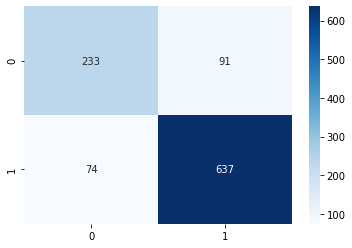

In [18]:
conf_mat = confusion_matrix(test_y, test_pred)
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='d');

In [19]:
tn, fp, fn, tp = conf_mat.ravel()
print('Sensibilidade: {:.4f}'.format(tp / (tp + fn)))
print('Especifidade: {:.4f}'.format(tn / (tn + fp)))

Sensibilidade: 0.8959
Especifidade: 0.7191


## Análise de efeito de Seleção de Variáveis a priori na modelagem

### Seleção de variáveis baseada no contagem de bits ativados

Selecionamos os bits ativados em pelo menos 10% das moléculas (observações), tanto em inibidores quanto não-inibidores, usando o conjunto de treino como referência.

De acordo com a Análise Exploratória de Dados, podemos supor que esses bits sejam mais úteis na separação entre inibidores e não-inibidores.

In [38]:
from scripts.preprocessing import selection_by_threshold

_, dropped_indeces_inhibitors = selection_by_threshold('incidence', train_X[train_y == 1], 0.1)
_, dropped_indeces_non_inhibitors = selection_by_threshold('incidence', train_X[train_y == 0], 0.1)

In [39]:
indices_to_drop = set(dropped_indeces_inhibitors).intersection(set(dropped_indeces_non_inhibitors))
print(len(indices_to_drop))

1931


In [40]:
clean_train_X = np.delete(train_X, np.array(list(indices_to_drop)), 1)
clean_train_X.shape

(4140, 117)

In [53]:
bagging_param_distribs = {
    'n_estimators': stats.randint(50, 250),
    'criterion': ['gini', 'entropy'],
    'max_depth': stats.randint(1, 20),
    'min_samples_leaf': stats.randint(5, 50),
    'max_samples': stats.loguniform(3e-1, 1)
}



bagging_estimators = {
    'xtrees': ExtraTreesClassifier(random_state=123),
    'rf': RandomForestClassifier(random_state=123)
}

search_objs_clean = {}

for name, estimator in bagging_estimators.items():
    rnd_search_cv = RandomizedSearchCV(estimator,
                                       param_distributions=bagging_param_distribs,
                                       scoring='accuracy', cv=5, n_iter=50, random_state=123,
                                       return_train_score=True, verbose=2, n_jobs=-1)
    rnd_search_cv.fit(clean_train_X, train_y)
    search_objs_clean[name] = rnd_search_cv
    
    
top_n = 3
for name in bagging_estimators:
    print(name, '-'*50)
    cv_test_scores = search_objs_clean[name].cv_results_['mean_test_score']
    top_results_idx = [*reversed(np.argsort(cv_test_scores))][:top_n]
    for i, idx in enumerate(top_results_idx):
        print(f'# {i}')
        print('test_score: {:.4f}'.format(cv_test_scores[idx]))
        for param in bagging_param_distribs:
            param_samples = search_objs_clean[name].cv_results_[f'param_{param}']
            print(f'{param}: ', param_samples[idx])

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
xtrees --------------------------------------------------
# 0
test_score: 0.8273
n_estimators:  189
criterion:  gini
max_depth:  18
min_samples_leaf:  8
max_samples:  0.6879025773510774
# 1
test_score: 0.8215
n_estimators:  155
criterion:  gini
max_depth:  16
min_samples_leaf:  12
max_samples:  0.6439261050375636
# 2
test_score: 0.8208
n_estimators:  159
criterion:  entropy
max_depth:  13
min_samples_leaf:  11
max_samples:  0.9349802999603081
rf --------------------------------------------------
# 0
test_score: 0.8162
n_estimators:  189
criterion:  gini
max_depth:  18
min_samples_leaf:  8
max_samples:  0.6879025773510774
# 1
test_score: 0.8157
n_estimators:  73
criterion:  gini
max_depth:  11
min_samples_leaf:  8
max_samples:  0.824031404652013
# 2
test_score: 0.8140
n_estimators:  159
criterion:  entropy
max_depth:  13
min_samples_leaf:  11
max_samples:  0.934980

In [54]:
boosting_param_distribs = {
                            'n_estimators': stats.randint(50, 250),
                            'warm_start': [True, False],
                            'max_depth': stats.randint(10, 20),
                            'min_samples_leaf': stats.randint(10, 50),
                            'learning_rate': stats.loguniform(3e-1, 0.5)
                           }
                          


boosting_estimators = {
    'gb': GradientBoostingClassifier(random_state=123),    
}

search_objs3 = {}

for name, estimator in boosting_estimators.items():
    rnd_search_cv = RandomizedSearchCV(estimator,
                                       param_distributions=boosting_param_distribs,
                                       scoring='accuracy', cv=5, n_iter=10, random_state=123,
                                       return_train_score=True, verbose=2, n_jobs=-1)
    rnd_search_cv.fit(clean_train_X, train_y)
    search_objs3[name] = rnd_search_cv
    
    
top_n = 3
for name in boosting_estimators:
    print(name, '-'*50)
    cv_test_scores = search_objs3[name].cv_results_['mean_test_score']
    top_results_idx = [*reversed(np.argsort(cv_test_scores))][:top_n]
    for i, idx in enumerate(top_results_idx):
        print(f'# {i}')
        print('test_score: {:.4f}'.format(cv_test_scores[idx]))
        for param in boosting_param_distribs:
            param_samples = search_objs3[name].cv_results_[f'param_{param}']
            print(f'{param}: ', param_samples[idx])  

Fitting 5 folds for each of 10 candidates, totalling 50 fits
gb --------------------------------------------------
# 0
test_score: 0.8408
n_estimators:  125
warm_start:  True
max_depth:  15
min_samples_leaf:  10
learning_rate:  0.4436663578697866
# 1
test_score: 0.8403
n_estimators:  52
warm_start:  True
max_depth:  11
min_samples_leaf:  13
learning_rate:  0.40632894398697755
# 2
test_score: 0.8391
n_estimators:  126
warm_start:  True
max_depth:  12
min_samples_leaf:  43
learning_rate:  0.36089728556841344


Como observado, infelizmente essa lógica simples de seleção de variáveis não ajuda significativamente na performance. Portanto, segue-se com o modelo treinado contendo todos os dados.